In [1]:
import json
import numpy as np
import pandas as pd

from tqdm import tqdm
import sys
sys.path.append("..")

from eval.eval_utils import *
from eval.eval_1022 import *

eval_data = json.load(open("/home/pcarragh/dev/webqa/LLaVA/WebQA_train_val_color_gpt_matched.json", "r"))
eval_data = {k: v for k, v in eval_data.items() if v['Qcate'].lower() in ['shape', 'color']}
perturbation_path = "/home/pcarragh/dev/webqa/segment/Inpaint-Anything/results/webqa"
use_split = True
save = False

keys = list(eval_data.keys())
version = "1"

model_path = "Qwen/Qwen2-VL-7B-Instruct" #Qwen/Qwen2-VL-72B-Instruct-AWQ
model, processor = get_model_processor(model_path)
conversational_prompt = not 'Phi' in model_path

results = {}
output_file = "qa_check_perturbations"
with open(f"data/{output_file}_v{version}.csv", "w") as f:
    f.write("model,question_id,image_id,gen_id,qa_check\n")

qa_check_answers = {}
for k in tqdm(keys): 
    example = eval_data[k]
    qa_check_answers[k] = {}
    for img in example['img_posFacts']:
        original_image_file = str(img['image_id'])
        qcate = example['Qcate'].lower()
        orig_answer = example['A'][0]
        orig_answer = normalize_text(orig_answer)
        
        # TODO: does getting first term mess up QA check for answers with multiple labels?
        orig_answer = find_first_search_term(orig_answer, domain_dict[qcate], qcate, orig_answer)
        qa_check_answers[k][original_image_file] = {}
        
        # TODO: on server, we have perturbations for both images, need another index
        for idx, label in example['A_perturbed'].items():
            counterfactual_image_file = f"{perturbation_path}/{example['split']}/{original_image_file}_{k}_{idx}.jpeg"
            
            question = f"Q: has the {qcate} of the {example['Q_obj']} changed from {orig_answer} in the original image to {label} in the perturbed image?"
            messages = get_qa_check_prompt(question, conversational_prompt)
            try:
                images = get_images([original_image_file, counterfactual_image_file])
            except Exception as e:
                print(f"Error: {e}")
                continue
            qa_check = run_inference(messages, images, processor, model, conversational_prompt)

            qa_check_answers[k][original_image_file][idx] = qa_check
            with open(f"data/{output_file}_v{version}.csv", "a") as f:
                f.write(f"{model_path},{k},{original_image_file},{idx},{qa_check}\n")
                    

/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
  0%|          | 0/572 [00:00<?, ?it/s]/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pcarragh/miniconda3/envs/lmms-finetune/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, 

Error: [Errno 2] No such file or directory: '/home/pcarragh/dev/webqa/segment/Inpaint-Anything/results/webqa/val/30112308_d5bdb11e0dba11ecb1e81171463288e9_0.jpeg'
Error: [Errno 2] No such file or directory: '/home/pcarragh/dev/webqa/segment/Inpaint-Anything/results/webqa/val/30112308_d5bdb11e0dba11ecb1e81171463288e9_2.jpeg'


  1%|          | 5/572 [00:16<29:23,  3.11s/it]

Error: [Errno 2] No such file or directory: '/home/pcarragh/dev/webqa/segment/Inpaint-Anything/results/webqa/val/30021316_d5c09ca80dba11ecb1e81171463288e9_2.jpeg'


  1%|          | 6/572 [00:20<32:29,  3.44s/it]


KeyboardInterrupt: 

False
{'1': '\nYou are a helpful assistant.\nuser\nCaption: original imageCaption: perturbed imageQ: has the color of the Shirt changed from grey in the original image to red in the perturbed image?\nassistant\nYes, the color of the shirt has changed from grey in the original image to red in the perturbed image.'}


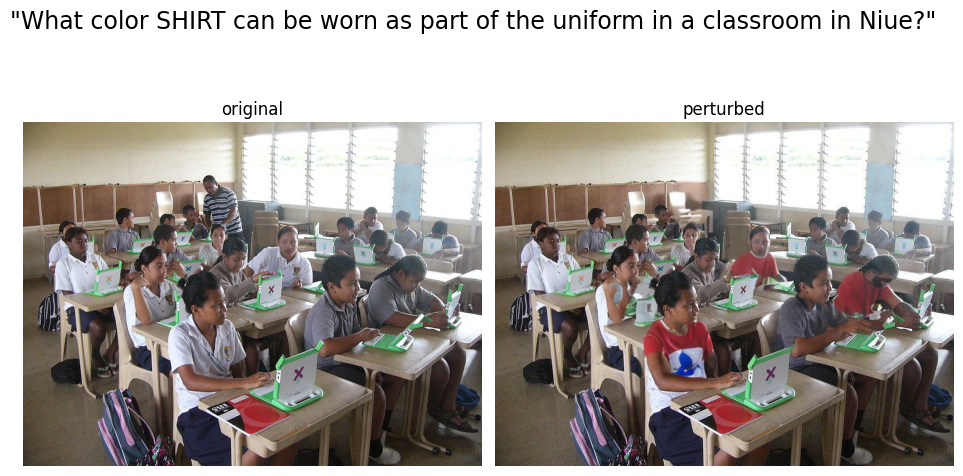

In [4]:
%matplotlib inline

# compare perturbed and original image side by side
perturbation_detected_keys = [(k, img_id, gen_id) for k,imgs in qa_check_answers.items() for img_id,gens in imgs.items() for gen_id, ans in gens.items() if 'yes' in ans.lower()]
perturbation_undetected_keys = [(k, img_id, gen_id) for k,imgs in qa_check_answers.items() for img_id,gens in imgs.items() for gen_id, ans in gens.items() if 'no' in ans.lower()]
# example_keys = [(k, id) for k, id in perturbation_detected_keys if len(eval_data[k]['img_posFacts']) == 1]
example_keys = perturbation_detected_keys

key, image_id, gen_id = example_keys[random.randint(0, len(example_keys))]
imgs = get_images([image_id, f"{perturbation_path}/{eval_data[key]['split']}/{str(image_id)}_{key}_{gen_id}.jpeg"])
q = capitalize_word_in_sentence(eval_data[key]['Q'], eval_data[key]['Q_obj'])

print(image_equals(imgs[0], imgs[1]))
print(qa_check_answers[key][image_id])
display_images(imgs[0], imgs[1], q, "original", "perturbed", savefile=False)

In [209]:
# print(len(perturbation_detected_keys))
# # dump keys to csv
# import csv
# with open(f"results/counterfactual_qa_check.csv", "w") as f:
#     writer = csv.writer(f)
#     writer.writerows(perturbation_detected_keys)

787


: 